Dataset 1 - Training Data Accuracy:  98.88888888888889
Dataset 1 - Validation Data Accuracy:  98.88888888888889
Dataset 1 - Test Data Accuracy:  100.0


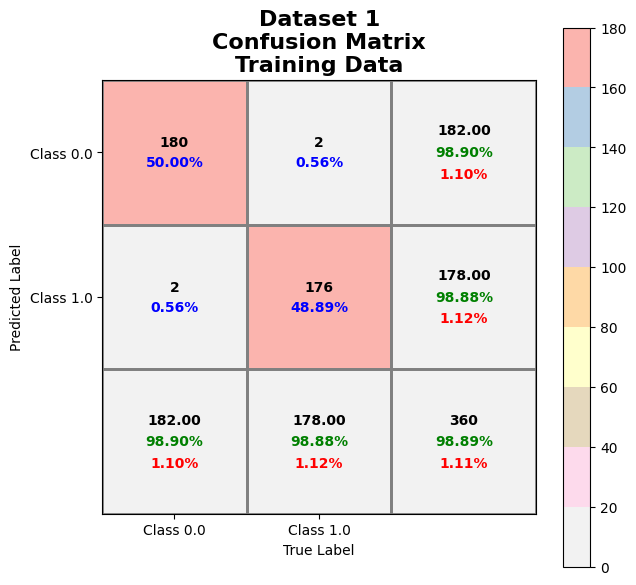

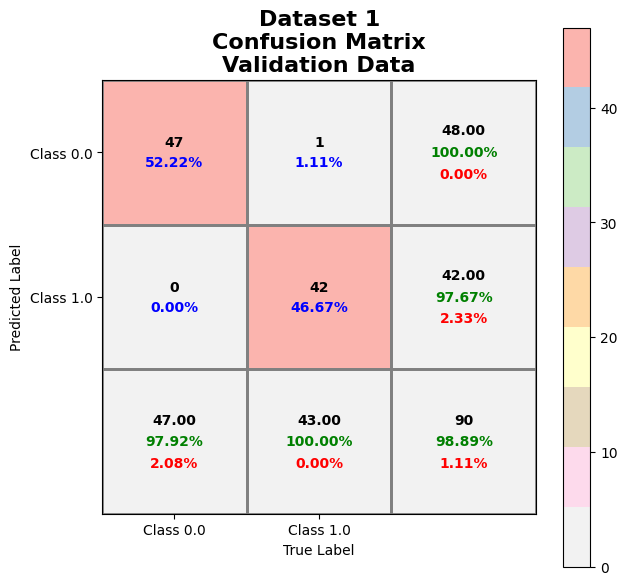

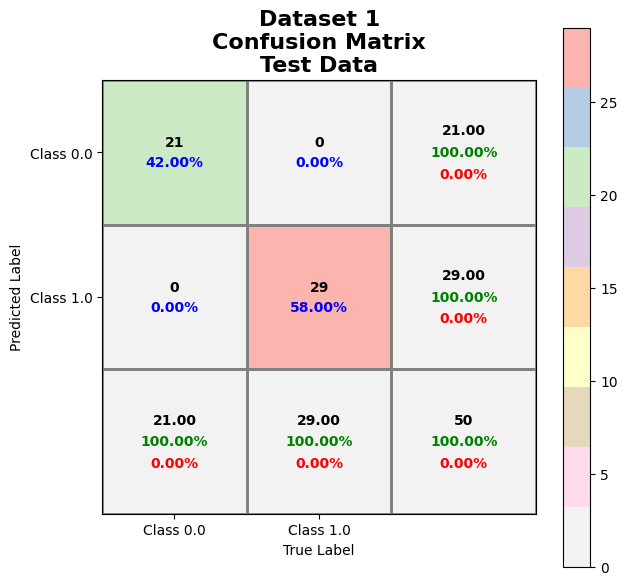

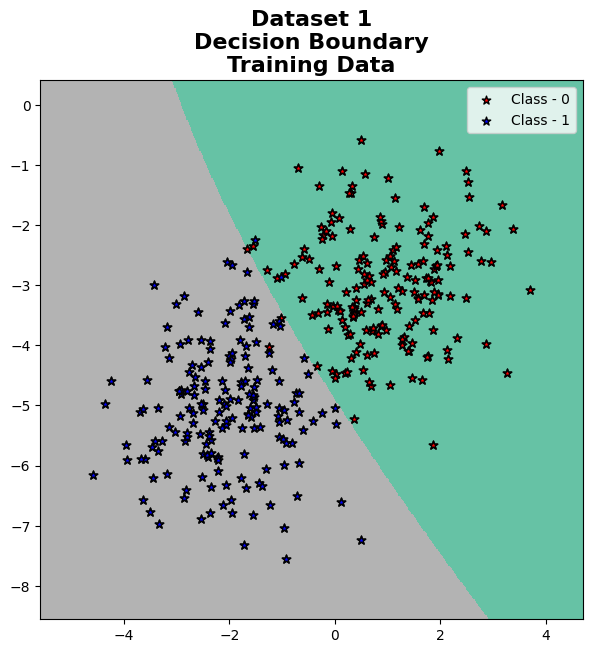

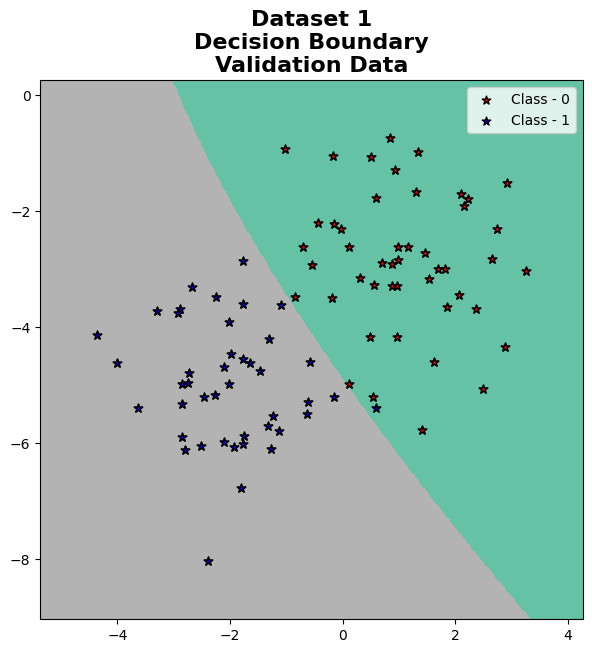

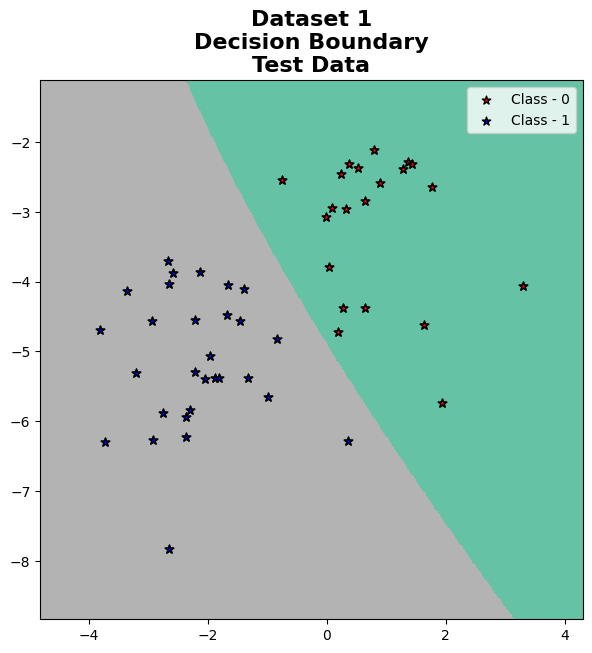

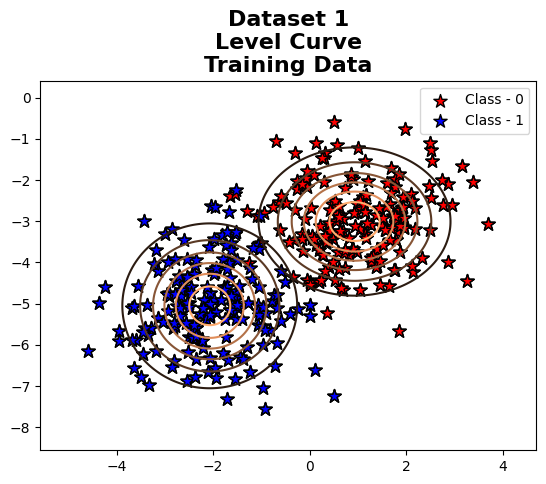

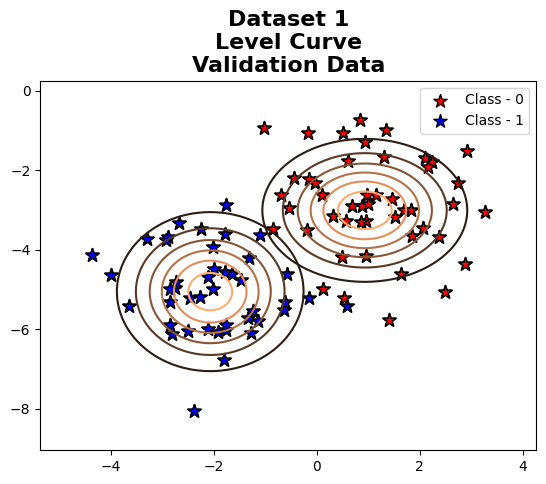

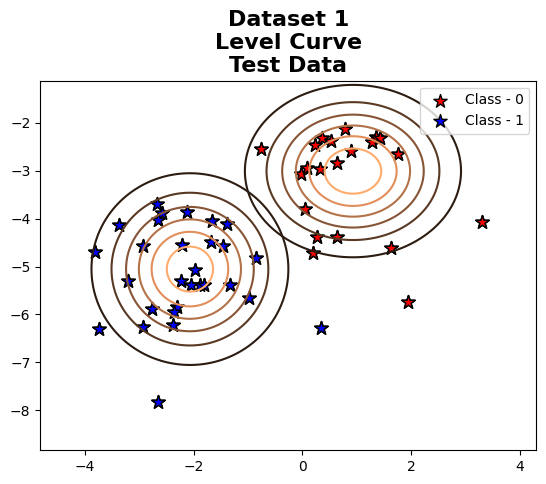

Dataset 2 - Training Data Accuracy:  100.0
Dataset 2 - Validation Data Accuracy:  100.0
Dataset 2 - Test Data Accuracy:  100.0


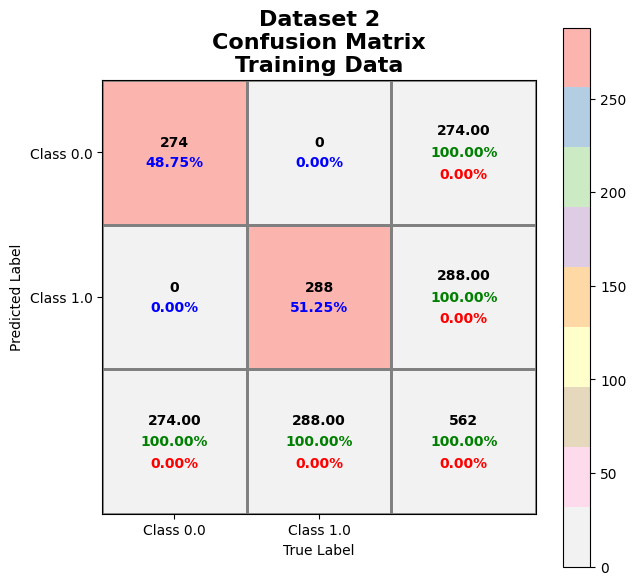

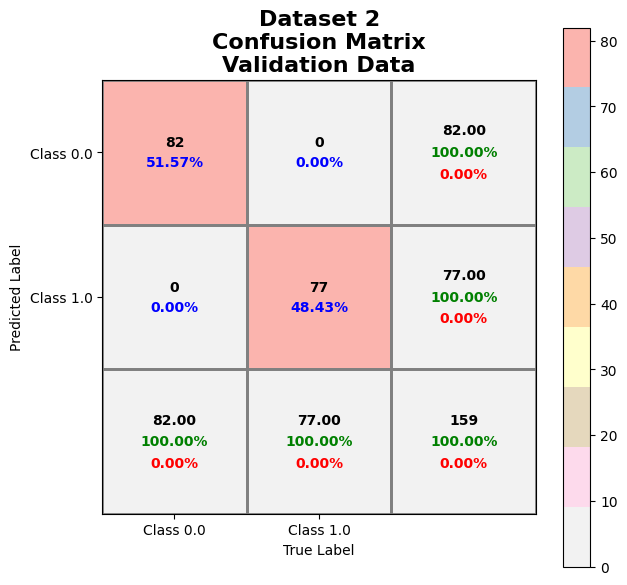

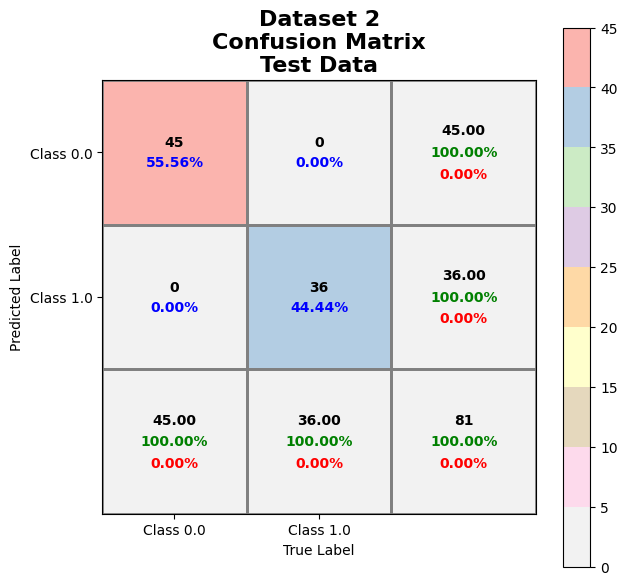

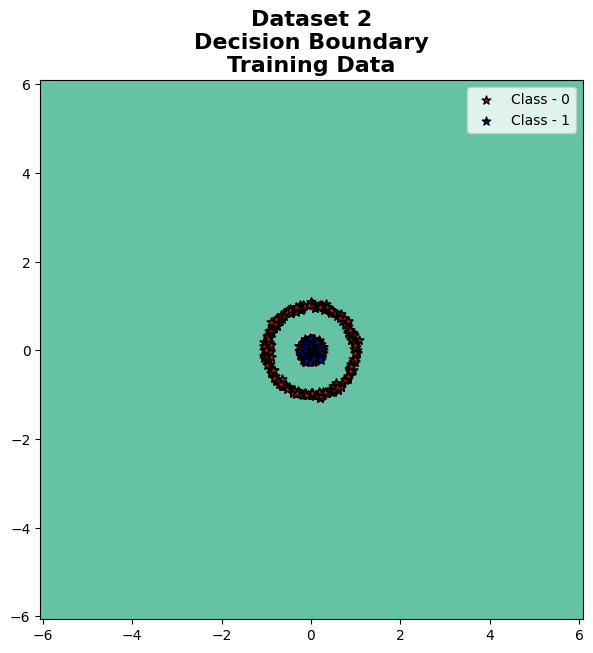

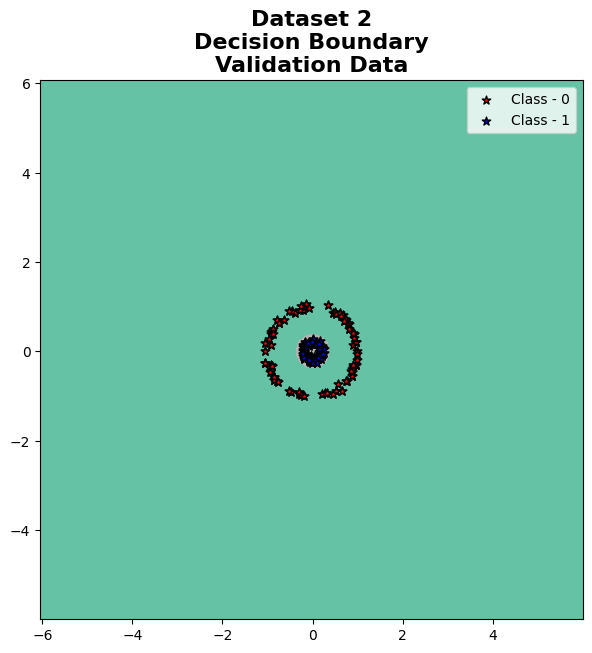

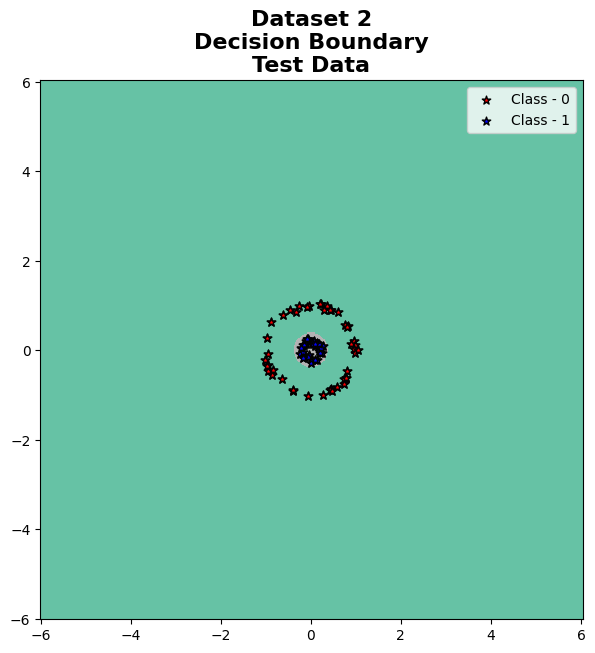

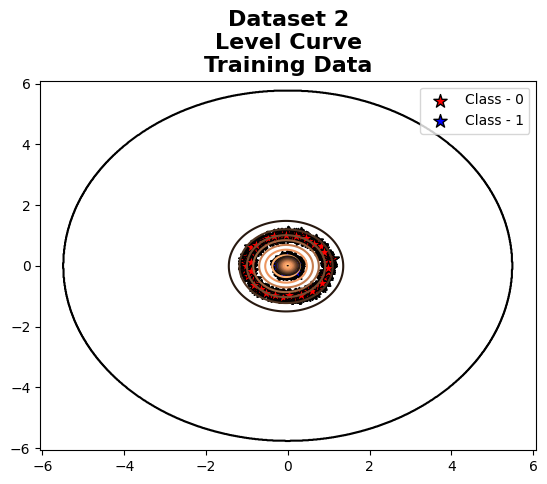

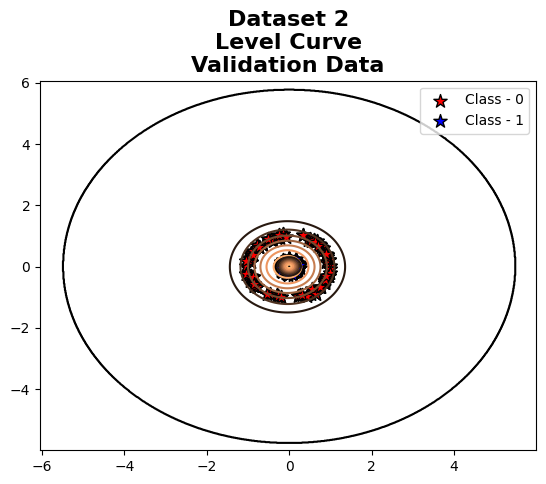

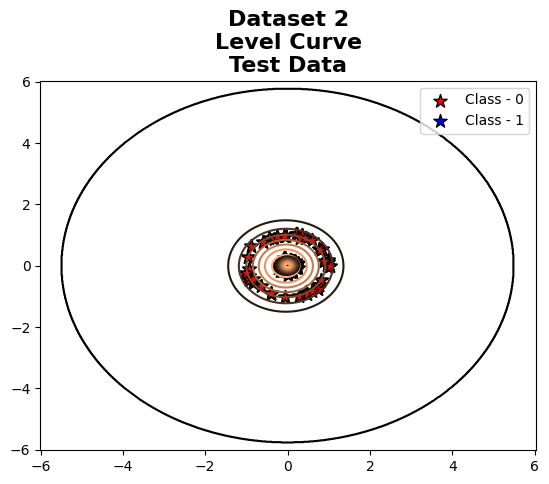

Dataset 3 - Training Data Accuracy:  56.33038010860246
Dataset 3 - Validation Data Accuracy:  56.05605605605606
Dataset 3 - Test Data Accuracy:  53.707414829659314


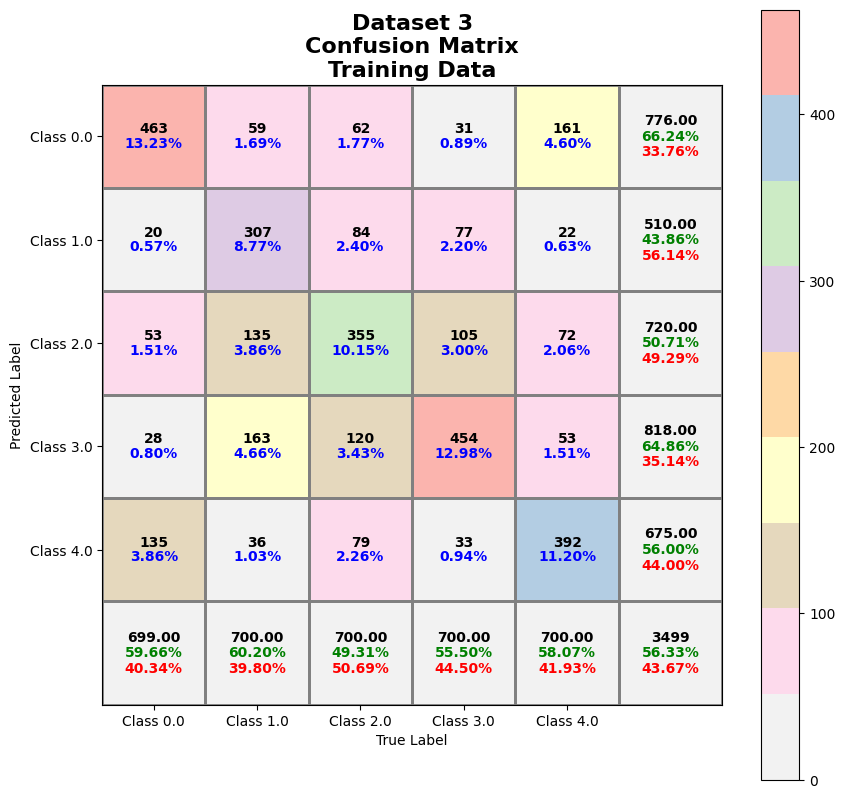

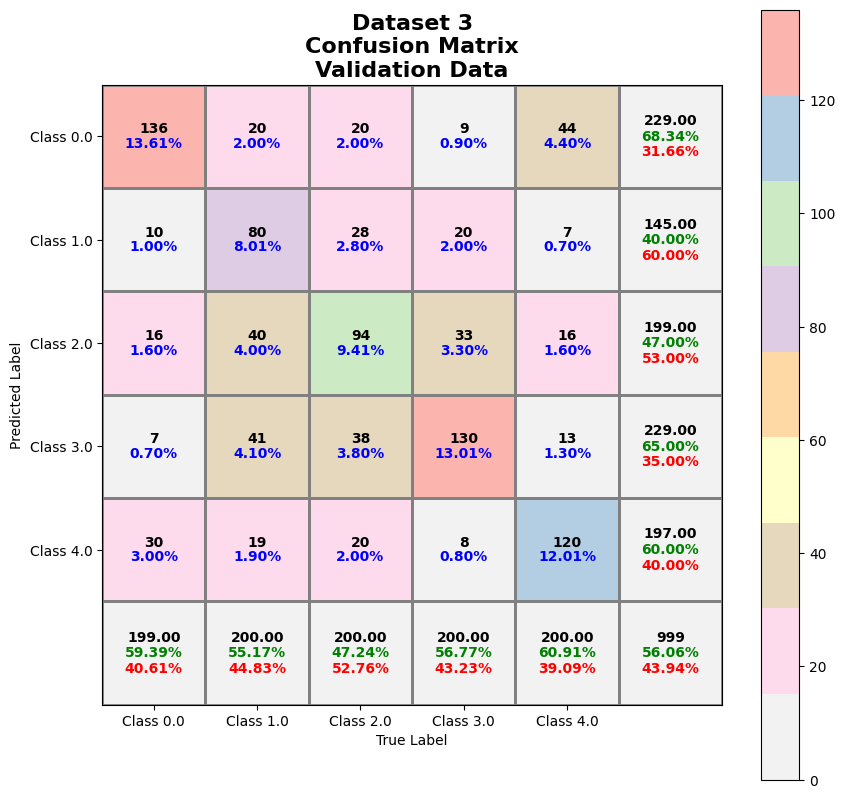

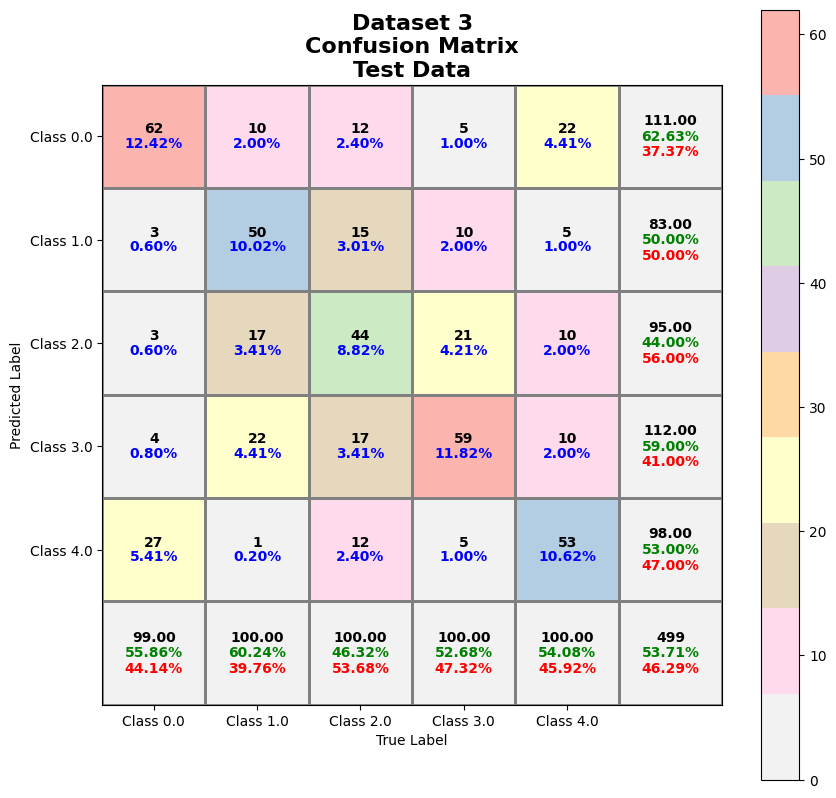

In [1]:
"""
Task 5. 
    Input -
        Datasets_for_A1 folder needs to be in the current working 
        directory with the folder structure as 
        Datasets_for_A1/Classification/Dataset <dataset number>/<team number>/
        Replace <team number> with the actual number.
        e.g. Datasets_for_A1/Classification/Dataset 1/9/
    Output -
        Naive-Bayes classifier with a Gaussian distribution for each class
            Covariance matrix for each class is different
        Presentation of Results:
            1. Table of classification accuracies of the model on training 
            data and validation data for different values of hyperparameter
            2. Classification accuracy of the best configuration of the 
            model on test data
            3. Confusion matrix for the best configuration of the model,
            on training data and test data
            4. Decision region plots for the best configuration of the model,
            for Datasets 1 and 2. Superpose the training data on the decision
            region plot. For the Bayes classifiers and naive-Bayes classifiers,
            superpose the plots of level curves on the training data.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


class NaiveBayesClassifier:
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        class_counts = []
        for cls in self.classes:
            count = np.sum(y_train == cls)
            class_counts.append(count)
        total_samples = len(y_train)
        self.class_priors = np.array(class_counts) / total_samples
        class_data = []
        for cls in self.classes:
            data = X_train[y_train == cls]
            class_data.append(data)

        self.class_means = []
        for class_ in class_data:
            mean_vector = np.mean(class_, axis=0)
            self.class_means.append(mean_vector)

        self.class_covs = []
        for class_ in class_data:
            cov_matrix = np.diag(np.diag(np.cov(class_.T)))
            self.class_covs.append(cov_matrix)

    def predict(self, X_test):
        likelihoods = []
        for class_mean, class_cov in zip(self.class_means, self.class_covs):
            likelihood = self.calculate_likelihood(X_test, class_mean, class_cov)
            likelihoods.append(likelihood)
        likelihoods = np.array(likelihoods)

        evidence = np.zeros(X_test.shape[0])
        for i in range(len(self.classes)):
            evidence += likelihoods[i] * self.class_priors[i]
        posteriors = likelihoods * self.class_priors[:, np.newaxis] / evidence
        return np.argmax(posteriors, axis=0)

    def calculate_likelihood(self, X, class_mean, class_cov):
        d = X.shape[1]
        constant = 1 / ((2 * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(class_cov)))
        mean_diff = X - class_mean
        exponent = -0.5 * np.sum(
            np.dot(mean_diff, np.linalg.inv(class_cov)) * mean_diff, axis=1
        )
        return constant * np.exp(exponent)


def custom_unique(input_array):
    unique_list = []
    for item in input_array:
        if item not in unique_list:
            unique_list.append(item)
    return np.array(unique_list)


def custom_mean(input_array):
    return sum(input_array) / len(input_array)


def custom_covariance_matrix(X):
    mean_vector = custom_mean(X)
    centered_data = X - mean_vector
    covariance_matrix = np.dot(centered_data.T, centered_data) / (X.shape[0] - 1)
    return covariance_matrix


def custom_std(feature):
    mean = np.mean(feature)
    squared_diff = np.square(feature - mean)
    variance = np.mean(squared_diff)
    std = np.sqrt(variance)
    return std


def accuracy_score(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Number of true labels and predicted labels must be the same.")
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total = len(y_true)
    accuracy = correct / total
    return accuracy


def confusion_matrix(y_true, y_pred, accuracy, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    num_labels = len(labels)
    cm = np.zeros((num_labels + 1, num_labels + 1), float)
    label_to_index = {label: i for i, label in enumerate(labels)}
    true_positives = np.zeros(num_labels)
    pred_positives = np.zeros(num_labels)
    total_samples = len(y_true)
    for true, pred in zip(y_true, y_pred):
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]
        cm[true_index, pred_index] += 1
        true_positives[true_index] += 1 if true == pred else 0
        pred_positives[pred_index] += 1 if true == pred else 0
    cm = cm.T
    accuracy = np.sum(np.diag(cm)) / total_samples
    cm[-1, :-1] = (true_positives / np.sum(cm[:-1, :-1], axis=1)) * 100
    cm[:-1, -1] = (pred_positives / np.sum(cm[:-1, :-1], axis=0)) * 100
    cm[-1, -1] = accuracy * 100
    return cm


def plot_confusion_matrix(y_true, y_pred, accuracy, title):
    cm = confusion_matrix(y_true, y_pred, accuracy)
    cm_backup = confusion_matrix(y_true, y_pred, accuracy)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 or j == cm.shape[1] - 1:
                cm[i, j] = 0.0
    number_of_classes = len(np.unique(y_true))
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Pastel1_r)
    cm = cm_backup
    plt.title(title, fontsize=16, weight='bold')
    plt.colorbar()
    labels = []
    for i in np.unique(y_true):
        label = "Class " + str(i)
        labels.append(label)
    plt.xticks(range(len(np.unique(y_true))), labels=labels)
    plt.yticks(range(len(np.unique(y_true))), labels=labels)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

    cm_except_last_row_col = cm[:-1, :-1]
    cm_row_sum = np.sum(cm_except_last_row_col, axis=1)
    cm_col_sum = np.sum(cm_except_last_row_col, axis=0)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        row_sum = 0
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 and j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(y_true.size, "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_row_sum[i], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif i == cm.shape[0] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_col_sum[j], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            else:
                percent = (cm[i, j] / y_true.size) * 100
                plt.text(
                    j,
                    i - 0.07,
                    format(int(cm[i, j]), "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i + 0.07,
                    format(percent, ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="blue",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)

    plt.grid(False)
    plt.show()


def plot_decision_boundary(x, y, classifier, title):
    N = 500

    adjust = 0
    if "Dataset 2" in title:
        adjust = 4
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    x_range = np.linspace(x_min-adjust, x_max+adjust, N)
    y_range = np.linspace(y_min-adjust, y_max+adjust, N)
    xx, yy = np.meshgrid(x_range, y_range)

    Z_list = []

    for point in np.c_[xx.ravel(), yy.ravel()]:
        prediction = classifier.predict(np.array([point]))
        Z_list.append(prediction)

    Z = np.array(Z_list)

    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(["#9474b8", "#b874af", "#b874af"])
    classes = np.unique(y)
    number_of_classes = len(classes)
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    plt.pcolormesh(xx, yy, Z, cmap='Set2')
    # plt.scatter(
    #     x[:, 0],
    #     x[:, 1],
    #     c=y,
    #     cmap=ListedColormap(["#FF0000", "#00FF00", "#0000FF"]),
    #     edgecolors="k",
    #     marker="*",
    #     s=40,
    # )
    for class_label in classes:
        # Filter data points based on the current label
        x_label = x[y == class_label]
        # Plot only once with the label
        if class_label == classes[0]:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black", marker="*", s=40, label='Class - '+str(int(class_label)))
            # plt.legend()
        else:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", marker="*", s=40)
        if class_label == classes[1]:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", marker="*", s=40, label='Class - '+str(int(class_label)))
            # plt.legend()
        else:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black", marker="*", s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()
    plt.title(title, fontsize=16, weight='bold')
    plt.show()


def plot_level_curve(x, y, classifier, title):
    N = 1000

    adjust = 0
    if "Dataset 2" in title:
        adjust = 4
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    x_range = np.linspace(x_min-adjust, x_max+adjust, N)
    y_range = np.linspace(y_min-adjust, y_max+adjust, N)
    xx, yy = np.meshgrid(x_range, y_range)

    pos = np.dstack((xx, yy))

    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    classes = np.unique(y)
    number_of_classes = len(classes)
    class0_label = False
    class1_label = False
    means = classifier.class_means
    covs = classifier.class_covs
    for mean, cov in zip(means, covs):
        Z = np.exp(
            -0.5 * np.sum((pos - mean) @ np.linalg.inv(cov) * (pos - mean), axis=2)
        ) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

        plt.contour(xx, yy, Z, cmap='copper')
        # plt.scatter(
        #     x[:, 0],
        #     x[:, 1],
        #     c=y,
        #     cmap=ListedColormap(["#FF0000", "#00FF00", "#0000FF"]),
        #     edgecolors="k",
        #     marker='*',
        #     s=100,
        # )
        for class_label in classes:
            # Filter data points based on the current label
            x_label = x[y == class_label]
            # Plot only once with the label
            if class_label == classes[0] and (not class0_label):
                plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black", marker="*", s=100, label='Class - '+str(int(class_label)))
                class0_label = True
                # plt.legend()
            elif not class_label == classes[0]:
                plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", marker="*", s=100)
            if class_label == classes[1] and (not class1_label):
                plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", marker="*", s=100, label='Class - '+str(int(class_label)))
                class1_label = True
                # plt.legend()
            elif not class_label == classes[1]:
                plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black", marker="*", s=100)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(title, fontsize=16, weight='bold')
        plt.legend()
    plt.show()


def read_dataset_1(current_directory, folder_number):
    # classification_dataset_1_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 1/" + folder_number + "/"
    classification_dataset_1_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Classification/Dataset 1/"
        + folder_number
        + "/"
    )

    classification_dataset_1_Train = (
        classification_dataset_1_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    classification_dataset_1_Validation = (
        classification_dataset_1_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    classification_dataset_1_Test = (
        classification_dataset_1_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y


def read_dataset_2(current_directory, folder_number):
    # classification_dataset_2_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 2/" + folder_number + "/"
    classification_dataset_2_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Classification/Dataset 2/"
        + folder_number
        + "/"
    )
    folder_number = "1"
    classification_dataset_2_Train = (
        classification_dataset_2_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_2_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    classification_dataset_2_Validation = (
        classification_dataset_2_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_2_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    classification_dataset_2_Test = (
        classification_dataset_2_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_2_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y


def read_dataset_3(current_directory, folder_number):
    # classification_dataset_2_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 3/" + folder_number + "/"
    classification_dataset_3_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Classification/Dataset 3/"
        + folder_number
        + "/"
    )

    classification_dataset_3_Train_data = classification_dataset_3_path + "train_data.csv"
    df = pd.read_csv(classification_dataset_3_Train_data)
    data = df.to_numpy()
    train_x = data

    classification_dataset_3_Train_label = classification_dataset_3_path + "train_label.csv"
    df = pd.read_csv(classification_dataset_3_Train_label)
    data = df.to_numpy()
    train_y = data[:, 0]

    classification_dataset_3_Validation_data = classification_dataset_3_path + "val_data.csv"
    df = pd.read_csv(classification_dataset_3_Validation_data)
    data = df.to_numpy()
    val_x = data

    classification_dataset_3_Validation_label = classification_dataset_3_path + "val_label.csv"
    df = pd.read_csv(classification_dataset_3_Validation_label)
    data = df.to_numpy()
    val_y = data[:, 0]

    classification_dataset_3_Test_data = classification_dataset_3_path + "test_data.csv"
    df = pd.read_csv(classification_dataset_3_Test_data)
    data = df.to_numpy()
    test_x = data

    classification_dataset_3_Test_label = classification_dataset_3_path + "test_label.csv"
    df = pd.read_csv(classification_dataset_3_Test_label)
    data = df.to_numpy()
    test_y = data[:, 0]

    return train_x, train_y, val_x, val_y, test_x, test_y


def generate_random_data():
    # Generate synthetic data
    np.random.seed(0)
    X_train = np.random.randn(300, 2)
    y_train = np.concatenate([np.zeros(150), np.ones(150)])

    X_val = np.random.randn(100, 2)
    y_val = np.concatenate([np.zeros(50), np.ones(50)])

    X_test = np.random.randn(100, 2)
    y_test = np.concatenate([np.zeros(50), np.ones(50)])

    return X_train, y_train, X_val, y_val, X_test, y_test


def apply_naive_classifier_diff_cov(
    train_x, train_y, val_x, val_y, test_x, test_y, dataset
):
    classifier = NaiveBayesClassifier()
    classifier.fit(train_x, train_y)

    train_y_pred = classifier.predict(train_x)
    val_y_pred = classifier.predict(val_x)
    test_y_pred = classifier.predict(test_x)

    train_accuracy = accuracy_score(train_y, train_y_pred) * 100
    val_accuracy = accuracy_score(val_y, val_y_pred) * 100
    test_accuracy = accuracy_score(test_y, test_y_pred) * 100

    print(dataset, "- Training Data Accuracy: ", train_accuracy)
    print(dataset, "- Validation Data Accuracy: ", val_accuracy)
    print(dataset, "- Test Data Accuracy: ", test_accuracy)

    plot_confusion_matrix(
        train_y,
        train_y_pred,
        train_accuracy,
        title=dataset + "\nConfusion Matrix\nTraining Data",
    )
    plot_confusion_matrix(
        val_y,
        val_y_pred,
        val_accuracy,
        title=dataset + "\nConfusion Matrix\nValidation Data",
    )
    plot_confusion_matrix(
        test_y,
        test_y_pred,
        test_accuracy,
        title=dataset + "\nConfusion Matrix\nTest Data",
    )

    if dataset != "Dataset 3":
        plot_decision_boundary(
            train_x,
            train_y,
            classifier,
            dataset + "\nDecision Boundary\nTraining Data",
        )
        plot_decision_boundary(
            val_x, val_y, classifier, dataset + "\nDecision Boundary\nValidation Data"
        )
        plot_decision_boundary(
            test_x, test_y, classifier, dataset + "\nDecision Boundary\nTest Data"
        )

        plot_level_curve(
            train_x, train_y, classifier, dataset + "\nLevel Curve\nTraining Data"
        )
        plot_level_curve(
            val_x, val_y, classifier, dataset + "\nLevel Curve\nValidation Data"
        )
        plot_level_curve(
            test_x, test_y, classifier, dataset + "\nLevel Curve\nTest Data"
        )


def main():
    # train_x, train_y, val_x, val_y, test_x, test_y = generate_random_data()

    folder_number = "25"
    current_directory = os.getcwd()

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_1(
        current_directory, folder_number
    )
    apply_naive_classifier_diff_cov(
        train_x, train_y, val_x, val_y, test_x, test_y, "Dataset 1"
    )

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_2(
        current_directory, folder_number
    )
    apply_naive_classifier_diff_cov(
        train_x, train_y, val_x, val_y, test_x, test_y, "Dataset 2"
    )

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_3(
        current_directory, folder_number
    )
    apply_naive_classifier_diff_cov(
        train_x, train_y, val_x, val_y, test_x, test_y, "Dataset 3"
    )


if __name__ == "__main__":
    main()